# Testing Informativeness and Headship with TFIDF 

In [1]:
from scripts.imports import *

df_ph = pd.read_csv(paths['phrase_dataset'], index_col='node', low_memory=False)

df_sgph = df_ph[
    (df_ph.n_heads == 1)
    & (df_ph.n_phatoms == 1)
].copy()

out = Exporter(
    paths['outdir'], 
    'headship_tfidf'
)

import ast

In [2]:
df_sgph.head()

,verse,book,booksuper,canon_part,period,heads_etcbc,heads_utf8,heads_utf8d,Phrase Heads,function,...,APPO,QUANT,SFX1,SFX2,DU,CARDC,HLOC,TIMEAPPO,ADVB,DEMON
node,,,,,,,,,,,,,,,,,,,,,
651542,Genesis 1:1,Genesis,Genesis,Law,SBH,R>CJT/,ראשׁית,תישאר,\texthebrew{ראשית},Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651544,Genesis 1:1,Genesis,Genesis,Law,SBH,>LHJM/,אלהים,םיהלא,\texthebrew{אלהים},Subj,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651547,Genesis 1:2,Genesis,Genesis,Law,SBH,>RY/,ארץ,ץרא,\texthebrew{ארץ},Subj,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651551,Genesis 1:2,Genesis,Genesis,Law,SBH,XCK/,חשׁך,ךשח,\texthebrew{חשך},Subj,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651552,Genesis 1:2,Genesis,Genesis,Law,SBH,THWM/,תהום,םוהת,\texthebrew{תהום},PreC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_sgph.shape

(100021, 49)

In [4]:
df_sgph.columns

Index(['verse', 'book', 'booksuper', 'canon_part', 'period', 'heads_etcbc',
       'heads_utf8', 'heads_utf8d', 'Phrase Heads', 'function', 'text',
       'n_heads', 'word_lexs', 'n_words', 'n_phatoms', 'clause_node', 'verb',
       'verbform', 'verb_etcbc', 'verb_txt', 'clause', 'sentence', 'cl_rela',
       'domain', 'genre', 'gendom', 'cl_kind', 'PP', 'unmodified', 'PL', 'ØPP',
       'PARA', 'DEF', 'GP', 'NUM', 'SPEC', 'ADJV', 'SFX3', 'SFX', 'APPO',
       'QUANT', 'SFX1', 'SFX2', 'DU', 'CARDC', 'HLOC', 'TIMEAPPO', 'ADVB',
       'DEMON'],
      dtype='object')

# Extract the wordcounts per phrase

In [5]:
df_sgph['word_lexs'].head() # show a sample

node
651542         B R>CJT/
651544           >LHJM/
651547           H >RY/
651551             XCK/
651552    <L PNH/ THWM/
Name: word_lexs, dtype: object

In [6]:
# first we do a split operation on the lexeme string 
# since lexemes are space-separated in dataset;
# expand ensures that each lexeme goes into its own column
exp_df = df_sgph[df_sgph.n_words > 1]

split_words = (
    exp_df['word_lexs']
        .str.split(expand=True)
)

print(split_words.shape)

split_words.head()

(53734, 22)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
node,,,,,,,,,,,,,,,,,,,,,
651542,B,R>CJT/,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
651547,H,>RY/,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
651552,<L,PNH/,THWM/,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
651554,RWX/,>LHJM/,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
651556,<L,PNH/,H,MJM/,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [7]:
# now use a stack operation to move all columns into
# a single column, grouped by the node index;
# this creates a mult-index

stacked_words = split_words.stack()

stacked_words.index[:5] # show the multi-index

MultiIndex([(651542, 0),
            (651542, 1),
            (651547, 0),
            (651547, 1),
            (651552, 0)],
           names=['node', None])

In [8]:
# show the stacked words
stacked_words.head()

node     
651542  0         B
        1    R>CJT/
651547  0         H
        1      >RY/
651552  0        <L
dtype: object

In [9]:
# finally, do a groupby operation to group the whole dataframe
# by the node number; we use value_counts as the grouping function
# in order to retrieve a count of lexemes
word_cts = stacked_words.groupby(by='node', level=0).value_counts()
word_cts.head()

node          
651542  B         1
        R>CJT/    1
651547  >RY/      1
        H         1
651552  <L        1
dtype: int64

In [10]:
word_cts[word_cts > 1][20:25] # show items with count > 1

node        
654554  CNH/    2
654590  H       2
655034  B>R/    2
655185  H       2
655281  H       2
dtype: int64

In [11]:
# # total N words per phrase
# nwords = word_cts.groupby(by='node', level=0).sum()

# # divide to get the relative frequency (percentage)
# rel_freqs = word_cts.div(nwords)
# rel_freqs

In [12]:
# re-organize into a DF
word_ct = (
    word_cts
        .reset_index()
        .pivot(index='node', columns='level_1', values=0)
        .fillna(0)
)

word_ct.head()

level_1,<B/,<B=/,<B==/,<BD/,<BDH/,<BDJH/,<BDJHW/,<BDT/,<BD[,<BD_>DWM/,...,ZRZJR/,ZTW>/,ZW/,ZWB/,ZWB[,ZWJT/,ZWLH/,ZWZJM/,ZXLT/,ZXL[
node,,,,,,,,,,,,,,,,,,,,,
651542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# now we can apply TFIDF to the data;

# first we calculate the term (relative) frequency (TF)
tf = word_ct.div(word_ct.sum(1), 0)

# next get number of phrases each term appears in;
# turn all counts into binary 0/1 value 
# and then sum across rows
n_in_ph = ((word_ct > 0) * 1).sum()

# get inverse document frequency
idf = np.log10(n_in_ph.shape[0] / n_in_ph)

# now tf-idf matrix
tfidf = tf.multiply(idf)

<AxesSubplot:xlabel='level_1'>

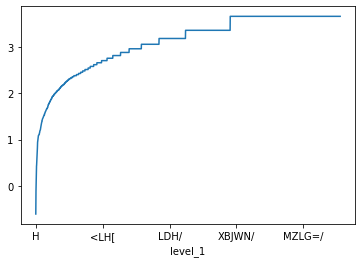

In [14]:
# plot idf scores
idf.sort_values().plot()

In [15]:
tfidf

level_1,<B/,<B=/,<B==/,<BD/,<BDH/,<BDJH/,<BDJHW/,<BDT/,<BD[,<BD_>DWM/,...,ZRZJR/,ZTW>/,ZW/,ZWB/,ZWB[,ZWJT/,ZWLH/,ZWZJM/,ZXLT/,ZXL[
node,,,,,,,,,,,,,,,,,,,,,
651542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# now get the index with the maximum value for tfidf;
# this is our prediction for the head-word based on the principle
# of informativity / heads as primary-information-bearing-unit
# we can use idxmax to do this:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html
head_predict = tfidf.idxmax(1)

head_predict

node
651542     R>CJT/
651547       >RY/
651552      THWM/
651554       RWX/
651556       MJM/
           ...   
904724      MKTB/
904729     MMLKH/
904740    JRWCLM/
904742     JHWDH/
904744        <M/
Length: 53734, dtype: object

In [17]:
# Calculate the accuracy of the predicted head by comparing
# with the parsed head values

In [18]:
head_df = pd.concat([head_predict, exp_df.heads_etcbc], 1)\
              .set_axis(['predict_head', 'actual_head'], 1)\
              .assign(predict_tfidf=tfidf.max(1))\
              .assign(
                  correct=(1 * (head_predict == exp_df.heads_etcbc))
              )\
              .assign(n_words=exp_df.n_words)

head_df.head()

,predict_head,actual_head,predict_tfidf,correct,n_words
node,,,,,
651542,R>CJT/,R>CJT/,1.097854,1,2
651547,>RY/,>RY/,0.203234,1,2
651552,THWM/,THWM/,0.817996,1,3
651554,RWX/,RWX/,0.649136,1,2
651556,MJM/,MJM/,0.277891,1,4


In [19]:
# finally, get the overall accuracy!

head_df.correct.sum() / head_df.correct.size

0.7559273458145681

Overall, the TFIDF method of informativeness predicts the correct head
76% of the time.

In [21]:
head_df[head_df.correct == 0].head(20)

,predict_head,actual_head,predict_tfidf,correct,n_words
node,,,,,
651590,>XD/,JWM/,0.476549,0,2
651626,CNJ/,JWM/,0.826893,0,2
651695,CLJCJ/,JWM/,0.936389,0,2
651744,RBJ<J/,JWM/,1.063314,0,2
651796,XMJCJ/,JWM/,1.201417,0,2
651802,XJ/,NPC/,0.900387,0,2
651881,PNH/,>RY/,0.087600,0,5
651894,XJ/,NPC/,0.900387,0,2
651916,CCJ/,JWM/,0.771895,0,3


In [33]:
head_df[head_df.correct == 0].head(20)

,predict_head,actual_head,predict_tfidf,correct,n_words
node,,,,,
651590,>XD/,JWM/,0.476549,0,2
651626,CNJ/,JWM/,0.826893,0,2
651695,CLJCJ/,JWM/,0.936389,0,2
651744,RBJ<J/,JWM/,1.063314,0,2
651796,XMJCJ/,JWM/,1.201417,0,2
651802,XJ/,NPC/,0.900387,0,2
651881,PNH/,>RY/,0.087600,0,5
651894,XJ/,NPC/,0.900387,0,2
651916,CCJ/,JWM/,0.771895,0,3


In [22]:
# look at accuracy by number of words in phrase

bynwords = pd.pivot_table(
    head_df,
    index='n_words',
    columns='correct',
    aggfunc='size',
    fill_value=0,
)

bynwords

correct,0,1
n_words,,
2,4106,25395
3,4841,11775
4,2114,2466
5,1529,727
6,297,158
7,117,54
8,33,20
9,24,12
10,15,7


In [23]:
bynwords_pr = bynwords.div(bynwords.sum(1), 0)

bynwords_pr

correct,0,1
n_words,,
2,0.139182,0.860818
3,0.291346,0.708654
4,0.461572,0.538428
5,0.677748,0.322252
6,0.652747,0.347253
7,0.684211,0.315789
8,0.622642,0.377358
9,0.666667,0.333333
10,0.681818,0.318182


<AxesSubplot:xlabel='n_words'>

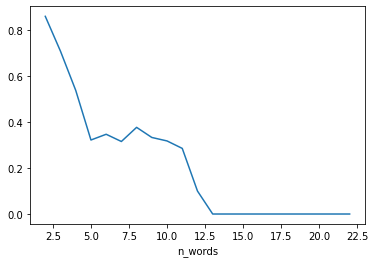

In [24]:
bynwords_pr[1].plot()